### Joshua Koonce
# Airline Tweet Sentiment Analysis

# Natural Language Processing

The objective of this project is to perform a sentiment analysis on Tweets related to major U.S. airlines. The dataset is data scraped from February of 2015, and each tweet was classified by contributors as positive, negative, or neutral. On negative tweets, reasons were also included since the negative tweets were the primary tweets of interest.

I'm tired of typing tweets, it's a terrible word.

Tweets.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

import warnings
warnings.filterwarnings("ignore")

seed = 1337

Import the Tweets dataset and store in a dataframe:

In [2]:
tweets = pd.read_csv('Tweets.csv')

In [3]:
tweets.head(2)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)


## Exploratory Data Analysis

In [4]:
tweets.shape

(14640, 15)

In [5]:
tweets.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

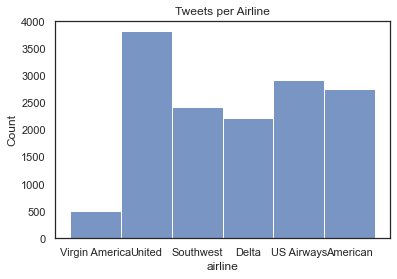

In [6]:
sns.histplot(tweets.airline);
plt.title('Tweets per Airline');

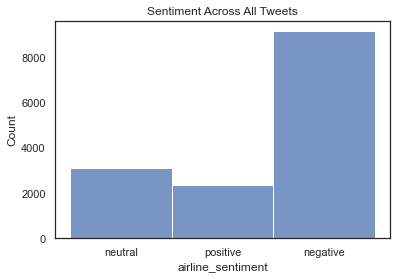

In [7]:
sns.histplot(tweets.airline_sentiment);
plt.title('Sentiment Across All Tweets');

So we can see that there are a lot more negative tweets than positive tweets. Can't say I'm surprised there.

In [8]:
tweets.airline.unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

Tweets by Sentiment by Airline:

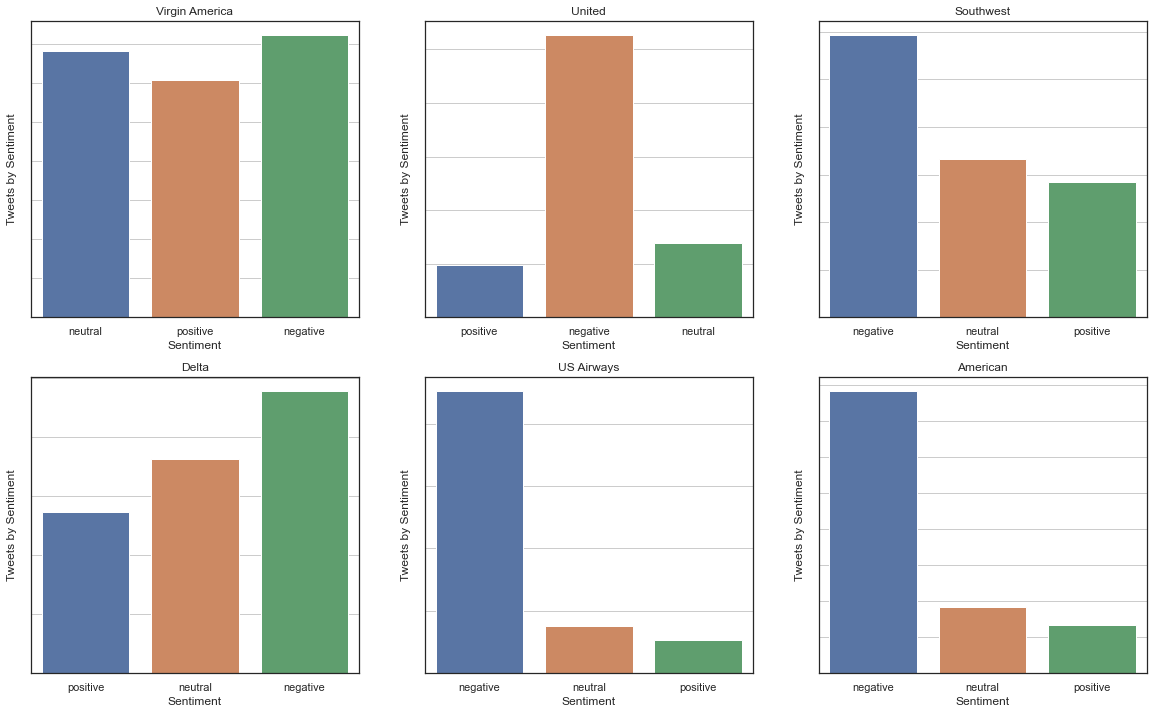

In [9]:
plt.figure(figsize=(20,12))    
    
for i, n in enumerate(tweets.airline.unique()):
    plt.subplot(2, 3, i + 1)

    ax = plt.gca()
    ax.axes.xaxis.set_ticklabels([])
    ax.axes.yaxis.set_ticklabels([])
    plt.grid(b=None)

    sns.countplot(x=tweets[tweets['airline'] == n].airline_sentiment)
    plt.title(n)
    plt.xlabel('Sentiment')
    plt.ylabel('Tweets by Sentiment')

plt.show()

In [10]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

Combine positive and negative tweets into one giant string for creating the wordclouds:

In [11]:
pos_tweets = " ".join(tweet for tweet in tweets[tweets['airline_sentiment'] == 'positive'].text)
neg_tweets = " ".join(tweet for tweet in tweets[tweets['airline_sentiment'] == 'negative'].text)

In [12]:
neg_tweets[:200]

'@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse @VirginAmerica and it\'s a really big bad thing about it @VirginAmerica se'

In [13]:
wordcloud_pos = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(pos_tweets)
wordcloud_neg = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(neg_tweets)

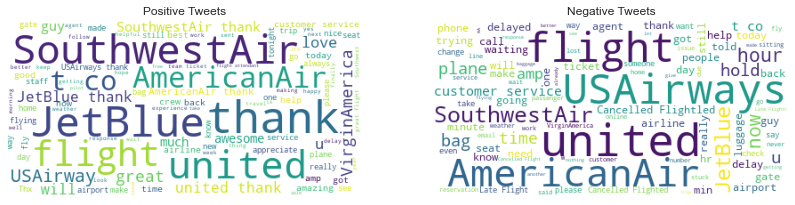

In [14]:
plt.figure(figsize=[14,7])
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos)
plt.title('Positive Tweets')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg)
plt.title('Negative Tweets')
plt.axis("off")
plt.show()

You can see from the wordclouds that some airlines appears to be getting more negative tweets than positive tweets and vice versa, but most airlines show up in both clouds.  You can also see some of the other words associated with the sentiments.

When I do my sentiment classifier, I'm going to want to take a lot of these proper nouns out because they'll give the model data it doesn't necessarily need in order to classify the sentiment in general.

## Understanding the Data

In [15]:
tweets.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

In [16]:
tweets.drop(['tweet_id', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'], axis=1, inplace=True)

In [17]:
tweets.shape

(14640, 2)

In [18]:
tweets.head(5)

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


## Text Pre-Processing Using NLP Libraries

In [19]:
import re, string, unicodedata
import contractions                                     
from bs4 import BeautifulSoup                                                  
import nltk                                            

from nltk.corpus import stopwords                       
from nltk.tokenize import word_tokenize, sent_tokenize 
from nltk.stem.wordnet import WordNetLemmatizer

In [20]:
stopwords = list(set(stopwords.words('english')))

I'm going to define the cleaning steps one by one then run them all sequentially.

In [21]:
def preprocess_text(text):
    
    ## @Mention Removal
    text = re.sub(r'@\w+', '', text)
    
    ## HTML Tag Removal
    soup = BeautifulSoup(text, "html.parser")                    
    text = soup.get_text()
    
    ## Remove Numbers
    text = re.sub(r'\d+', '', text)
    
    ## Remove Punctuation
    text = re.sub(r'[^\w\s]', '', text)    
    
    ## Remove Non-ASCII Characters
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    
    ## Convert to lowercase
    text = text.lower()
    
    return ''.join(text)

Run the cleaning steps above on the Series:

In [22]:
tweets['text'] = tweets['text'].apply(lambda x: preprocess_text(x))

In [23]:
tweets['text'].head()

0                                           what  said
1     plus youve added commercials to the experienc...
2     i didnt today must mean i need to take anothe...
3     its really aggressive to blast obnoxious ente...
4              and its a really big bad thing about it
Name: text, dtype: object

In [24]:
tweets['text'] = tweets.apply(lambda row: nltk.word_tokenize(row['text']), axis=1)
tweets.head()

,airline_sentiment,text
0,neutral,"[what, said]"
1,positive,"[plus, youve, added, commercials, to, the, exp..."
2,neutral,"[i, didnt, today, must, mean, i, need, to, tak..."
3,negative,"[its, really, aggressive, to, blast, obnoxious..."
4,negative,"[and, its, a, really, big, bad, thing, about, it]"


Since the text is now arrays of Tokens, it must be handled a little differently for subsequent steps.

First, removing stopwords:

In [25]:
def remove_stopwords(words):
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

tweets['text'] = tweets.apply(lambda row: remove_stopwords(row['text']), axis=1)

Now to lemmatize the words:

In [26]:
lemma = WordNetLemmatizer()

def lemmatize(words):
    new_words = []
    for word in words:
      new_words.append(lemma.lemmatize(word, pos='v'))
    return new_words

tweets['text'] = tweets.apply(lambda row: lemmatize(row['text']), axis=1)

In [27]:
tweets['text'].head()

0                                                [say]
1    [plus, youve, add, commercials, experience, ta...
2    [didnt, today, must, mean, need, take, another...
3    [really, aggressive, blast, obnoxious, enterta...
4                            [really, big, bad, thing]
Name: text, dtype: object

Join the lemmatized words back into a single string per row for feeding into the modeling process:

In [28]:
tweets['text'] = tweets.apply(lambda row: ' '.join(row['text']), axis=1)

In [29]:
tweets.head()

,airline_sentiment,text
0,neutral,say
1,positive,plus youve add commercials experience tacky
2,neutral,didnt today must mean need take another trip
3,negative,really aggressive blast obnoxious entertainmen...
4,negative,really big bad thing


In [30]:
from sklearn.preprocessing import LabelBinarizer

tweets['airline_sentiment'] = tweets['airline_sentiment'].map({ 'negative': 0, 'neutral': 1, 'positive': 2})

In [31]:
tweets.airline_sentiment.value_counts()

0    9178
1    3099
2    2363
Name: airline_sentiment, dtype: int64

In [32]:
y = tweets['airline_sentiment'].to_numpy()
y

array([1, 2, 1, ..., 1, 0, 1], dtype=int64)

## Vectorization Using CountVectorizer and TfidfVectorizer

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

Instantiate vectorization objects:

In [34]:
count_vec = CountVectorizer()
tfid_vec = TfidfVectorizer()

Fit both vectorizers onto the text corpus:

In [35]:
count_vec.fit(tweets['text']);
tfid_vec.fit(tweets['text']);

Save the vectors:

In [36]:
x_count = count_vec.transform(tweets['text']).toarray()
x_tfid = tfid_vec.transform(tweets['text']).toarray()

# Model Building, Tuning, Evaluation

Create the train test split

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
# Create a holdout dataset to split into train/test, set 20% aside for final test
x_train_count, x_test_count, y_train_count, y_test_count = train_test_split(x_count, y, test_size=.20, stratify=y, random_state=1337)
x_train_tfid, x_test_tfid, y_train_tfid, y_test_tfid = train_test_split(x_tfid, y, test_size=.20, stratify=y, random_state=1337)

# Check the lengths of each set to ensure it worked
print([len(x) for x in [x_train_count, x_test_count, y_train_count, y_test_count]])
print([len(x) for x in [x_train_tfid, x_test_tfid, y_train_tfid, y_test_tfid]])

[11712, 2928, 11712, 2928]
[11712, 2928, 11712, 2928]


In [39]:
print(count_vec.transform(tweets['text']).shape)
print(count_vec.transform(tweets['text']).shape)

(14640, 11835)
(14640, 11835)


Import various classification tools:

In [40]:
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

# establish the kfold
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

Define a function to display training metrics for a Kfold on a basic model:

In [41]:
def display_kfold_metrics(model, kfold, x_train, y_train):
        
    # Calculate metrics on each pair of training/test folds and return the mean score
    acc = round(np.mean(cross_val_score(estimator=model, X=x_train, y=y_train, scoring='accuracy', cv=kfold, n_jobs=16)), 2)
    rec = round(np.mean(cross_val_score(estimator=model, X=x_train, y=y_train, scoring='recall_macro', cv=kfold, n_jobs=16)), 2)
    
    # Display to console
    print("KFold Training Set Metrics: KFold=", kfold.get_n_splits())
    print('Accuracy: ', acc)
    print('Recall: ', rec)

Define a function to display a confusion matrix against the test set:

In [42]:
def build_confusion_matrix(model, x_test, y_test):
            
    # predictions on test set
    test_pred = model.predict(x_test)

    print("\nConfusion Matrix for Test Metrics")
    # create the confusion matrix
    conf_matrix = confusion_matrix(y_test, test_pred)
    
    # create the heatmap display
    heatmap = sns.heatmap(conf_matrix, cmap='magma', annot=True, fmt='d');
    heatmap.set_ylabel('actual')
    heatmap.set_xlabel('prediction')
    heatmap.plot()
    
    test_acc = round(metrics.accuracy_score(y_test, test_pred), ndigits=2)
    test_rec = round(metrics.recall_score(y_test, test_pred, average='macro'), ndigits=2)


    print("\nTest Set Metrics: ")
    print('Accuracy: ', test_acc)
    print('Recall: ', test_rec)

## Building the model with Count Vectorization

In [43]:
from sklearn.ensemble import RandomForestClassifier

In [44]:
model = RandomForestClassifier()

See how the baseline RandomForest model works using a kfold cross validation:

In [45]:
display_kfold_metrics(model, kfold, x_train_count, y_train_count)

KFold Training Set Metrics: KFold= 5
Accuracy:  0.76
Recall:  0.66


Attempt to tune the model with a hyperparameter grid search:

In [46]:
# hyperparameters
hp = {'n_estimators': np.arange(50, 210, 50),
      'max_features': ['auto', 'sqrt'],
      'max_depth': [5, 10, None],
      'min_samples_split' : [2, 5, 10, 20]}

rf_tuned_count = GridSearchCV(estimator=model, param_grid=hp, n_jobs=16, scoring='accuracy', cv=kfold)

Fit the model to the training data

In [47]:
%%time
rf_tuned_count.fit(x_train_count, y_train_count);
print("Best Parameters: ", rf_tuned_count.best_params_)
print("Best Score: ", rf_tuned_count.best_score_)

Best Parameters:  {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 5, 'n_estimators': 200}
Best Score:  0.7682714249943415
CPU times: total: 1min 45s
Wall time: 36min 31s


Display the confusion matrix to get an idea of performance


Confusion Matrix for Test Metrics

Test Set Metrics: 
Accuracy:  0.77
Recall:  0.65


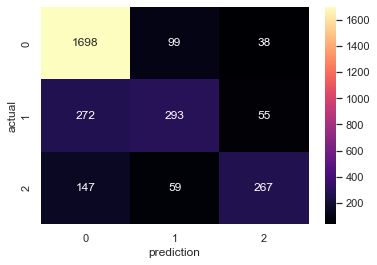

In [48]:
build_confusion_matrix(rf_tuned_count.best_estimator_, x_test_count, y_test_count)

## Building the model with Tf-Idf Vectorization
Tf-Idf vectorization implements a "penalty" on the importance of words that appear very frequently throughout the entire corpus (all the tweets). This can reduce the weight given to words that don't necessarily indicate any unique information

Re-create the Random Forest classifier:

In [49]:
model = RandomForestClassifier()

See how the baseline RandomForest model works using a kfold cross validation:

In [50]:
display_kfold_metrics(model, kfold, x_train_tfid, y_train_tfid)

KFold Training Set Metrics: KFold= 5
Accuracy:  0.76
Recall:  0.64


Tune the model using Grid Search

In [51]:
# hyperparameters
hp = {'n_estimators': np.arange(50, 210, 50),
      'max_features': ['auto', 'sqrt'],
      'max_depth': [5, 10, None],
      'min_samples_split' : [2, 5, 10, 20]}

rf_tuned_tfid = GridSearchCV(estimator=model, param_grid=hp, n_jobs=16, scoring='accuracy', cv=kfold)

Fit the model to the training data

In [52]:
%%time
rf_tuned_tfid.fit(x_train_tfid, y_train_tfid);
print("Best Parameters: ", rf_tuned_tfid.best_params_)
print("Best Score: ", rf_tuned_tfid.best_score_)

Best Parameters:  {'max_depth': None, 'max_features': 'auto', 'min_samples_split': 2, 'n_estimators': 200}
Best Score:  0.765282745303433
CPU times: total: 1min 53s
Wall time: 36min 29s


Display the confusion matrix to get an idea of performance


Confusion Matrix for Test Metrics

Test Set Metrics: 
Accuracy:  0.77
Recall:  0.64


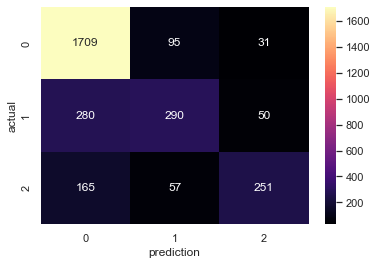

In [53]:
build_confusion_matrix(rf_tuned_tfid.best_estimator_, x_test_tfid, y_test_tfid)

#### Results
The tuned models performed no better than the untuned models at predicting sentiment. I attempted various other models as well (AdaBoost, XGBoost, DecisionTree) with similar results.

### Wordclouds of Top Tokens in Each Matrix

In [54]:
all_tokens_count = count_vec.get_feature_names()
all_tokens_tfid = tfid_vec.get_feature_names()

top_tokens_count = ''
top_tokens_tfid = ''

for i in np.argsort(rf_tuned_count.best_estimator_.feature_importances_)[::-1][:40]:
    top_tokens_count += all_tokens_count[i]
    top_tokens_count += ' ' 
    
for i in np.argsort(rf_tuned_tfid.best_estimator_.feature_importances_)[::-1][:40]:
    top_tokens_tfid += all_tokens_tfid[i]
    top_tokens_tfid += ' ' 
    
count_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(top_tokens_count)
tfid_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(top_tokens_tfid)

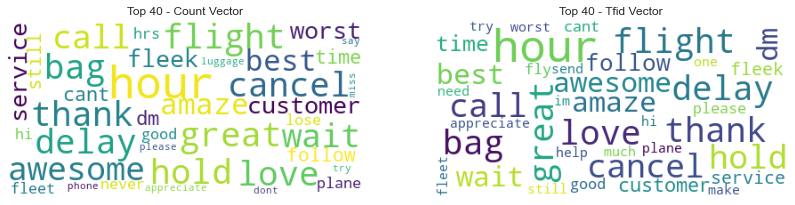

In [55]:
plt.figure(figsize=[14,7])
plt.subplot(1, 2, 1)
plt.imshow(count_wordcloud)
plt.title('Top 40 - Count Vector')
plt.axis("off")
plt.subplot(1, 2, 2)
plt.imshow(tfid_wordcloud)
plt.title('Top 40 - Tfid Vector')
plt.axis("off")
plt.show()

Notice that it's a lot easier to see which words occur most frequently with the proper nouns removed, and you can see the importances coming into play between the two approaches. Although the top features' importance varies between the two vector techniques, the results are fairly consistent between the two overall.

## Conclusion

Although this is a good initial start to building a sentiment analysis model, the results leave something to be desired. As you can see from the confusion matrices above, the model was only about 78% accurate with either vectorization approach. 

I may be able to improve this model in many ways, particularly given more time to explore the world of NLP. I would imagine much of the improvement would come from better text pre-processing and further understanding of how that relates to vectorization.

Some things I tried that did NOT improve results: 
- DecisionTree
- Other ensemble methods (AdaBoost, XGBoost)
- Oversampling to account for imbalanced classes

Some things I wanted to try, but did not due to time constraints:
- Artificial Neural Network
- Using Spacy instead

The models were certainly better than a random guess at detecting sentiment, but the accuracy was not up to my standards for calling a model "good".